# Table of Contents

### [Read Json From HDFS](#1.-Read-Json-From-HDFS)
### [Sensors DataFrame](#2.-Sensors-DataFrame)
### [Fails DataFrame](#3.-Fails-DataFrame)
### [Merge DataFrame Sensors and Fails](#4.-Merge-DataFrame-Sensors-and-Fails)
### [Parse time by minute](#5.-Parse-time-by-minute)
### [Parse time by hour](#6.-Parse-time-by-hour)
### [Create Hive Table](#7.-Create-Hive-Table)
### [H2O](#8.-H2O)
### [Auto-Arima](#9.-Auto-Arima)
### [Prophet](#10.-Prophet)

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import explode, min, max, col, round, hour, minute, count, dayofmonth, month, substring, avg
from pyspark.sql.types import IntegerType
from pyspark.sql.types import TimestampType
import pandas as pd
import numpy as np
import seaborn as sns

warehouse_location = 'hdfs://namenode:8020/warehouse'
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL Hive integration example") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .config("hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()

22/01/12 16:09:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# 1. Read Json From HDFS
         hdfs://namenode:8020//raw/fails
         hdfs://namenode:8020//raw/sensors

In [2]:
df_falhas = spark.read.json('hdfs://namenode:8020//raw/fails/1692abe5-8bd0-4a3e-acad-af18231c4114', multiLine = True)

df_sensores = spark.read.json('hdfs://namenode:8020//raw/sensors/8eebb26d-b551-4088-8ba0-9a63adc343de', multiLine = True)


In [3]:
df_sensores = df_sensores.withColumn("results", explode("results")) \
                    .withColumn("sensor_created_at", col("results")["sensor_created_at"].cast("timestamp")) \
                    .withColumn("sensor_event_type", col("results")["sensor_event_type"].cast("string")) \
                    .withColumn("sensor_id_cycle", col("results")["sensor_id_cycle"].cast("integer")) \
                    .withColumn("sensor_ip", col("results")["sensor_ip"].cast("string")) \
                    .withColumn("sensor_unique_id", col("results")["sensor_unique_id"].cast("string")) \
                    .withColumn("sensor_value_humidity", col("results")["sensor_value_humidity"].cast("integer")) \
                    .withColumn("sensor_value_temperature_motor1", col("results")["sensor_value_temperature_motor1"].cast("integer")) \
                    .withColumn("sensor_value_temperature_motor2", col("results")["sensor_value_temperature_motor2"].cast("integer")) \
                    .withColumn("sensor_value_temperature_motor3", col("results")["sensor_value_temperature_motor3"].cast("integer")) \
                    .withColumn("sensor_value_vibrationhz_x", col("results")["sensor_value_vibrationhz_x"].cast("integer")) \
                    .withColumn("sensor_value_vibrationhz_y", col("results")["sensor_value_vibrationhz_y"].cast("integer")) \
                    .withColumn("sensor_value_vibrationhz_z", col("results")["sensor_value_vibrationhz_z"].cast("integer")) \
                    .withColumn("value_noise_dba_motor1", col("results")["value_noise_dba_motor1"].cast("integer")) \
                    .withColumn("value_noise_dba_motor2", col("results")["value_noise_dba_motor2"].cast("integer")) \
                    .withColumn("value_noise_dba_motor3", col("results")["value_noise_dba_motor3"].cast("integer")) \
                    .drop("results") \
                    .orderBy("sensor_created_at")
df_sensores2 = df_sensores.toPandas()

In [4]:
df_falhas = df_falhas.withColumn("results", explode("results")) \
                .withColumn("falha_created_at", col("results")["falha_created_at"].cast("timestamp")) \
                .withColumn("falha_id_falha", col("results")["falha_id_falha"].cast("string")) \
                .withColumn("falha_ip", col("results")["falha_ip"].cast("string")) \
                .withColumn("falha_hostname", col("results")["falha_hostname"].cast("string")) \
                .withColumn("falha_event_type", col("results")["falha_event_type"].cast("string")) \
                .withColumn("falha_tipo_falha", col("results")["falha_tipo_falha"].cast("string")) \
                .withColumn("falha_error_code", col("results")["falha_error_code"].cast("string")) \
                .withColumn("falha_error_description", col("results")["falha_error_description"].cast("string")) \
                .drop("results") \
                .orderBy("falha_created_at")
df_falhas2 = df_falhas.toPandas()

## 2. Sensors DataFrame

In [5]:
df_sensores2

,sensor_created_at,sensor_event_type,sensor_id_cycle,sensor_ip,sensor_unique_id,sensor_value_humidity,sensor_value_temperature_motor1,sensor_value_temperature_motor2,sensor_value_temperature_motor3,sensor_value_vibrationhz_x,sensor_value_vibrationhz_y,sensor_value_vibrationhz_z,value_noise_dba_motor1,value_noise_dba_motor2,value_noise_dba_motor3
0,2021-11-25 12:25:35.015,sensor,4,172.18.0.2,e269fcc6-7737-410a-9bad-938f4d926247,23,19,28,8,11,14,20,23,47,23
1,2021-11-25 12:25:40.016,sensor,1,172.18.0.2,e461209a-82fe-4ce9-9fb2-d7cebd3b2fa5,22,26,21,27,19,16,20,39,58,46
2,2021-11-25 12:25:45.017,sensor,1,172.18.0.2,bf19c9e6-638a-47b0-a499-33878176943b,81,7,30,29,10,16,15,34,63,39
3,2021-11-25 12:25:50.019,sensor,4,172.18.0.2,26e31171-15f2-4005-b654-54a2e12dc4dc,41,18,23,11,18,11,21,26,20,44
4,2021-11-25 12:25:55.020,sensor,4,172.18.0.2,027c718e-a87e-453a-b0fb-e884f280db4a,42,11,32,17,12,15,14,36,28,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72235,2021-11-29 16:47:01.342,sensor,2,172.18.0.2,f087c835-37bc-4343-b647-118ab4849d0a,54,22,9,29,11,10,16,56,25,54
72236,2021-11-29 16:47:06.344,sensor,4,172.18.0.2,dc932a86-5e2b-49d3-a6bf-cd05b294216f,25,19,7,18,13,16,21,17,63,16
72237,2021-11-29 16:47:11.344,sensor,2,172.18.0.2,65f78734-bea7-465b-9523-99afab9dabd2,57,8,12,34,21,13,13,39,32,35
72238,2021-11-29 16:47:16.345,sensor,4,172.18.0.2,aadb443e-69fb-446e-8b4f-b3930f8bd762,46,6,31,18,19,19,12,59,51,64


## 3. Fails DataFrame

In [6]:
df_falhas2

,falha_created_at,falha_id_falha,falha_ip,falha_hostname,falha_event_type,falha_tipo_falha,falha_error_code,falha_error_description
0,2021-11-25 16:44:19.978,0c57eba9-1fb8-461a-af31-d0b33c77ee99,172.18.0.2,32e102a5111a,fail,falha_1,erro_500,Pequena falha
1,2021-11-25 16:44:25.021,65bd9df3-2310-4299-bba5-9185da1075a6,172.18.0.2,32e102a5111a,fail,falha_2,erro_500,Falha Geral
2,2021-11-25 16:44:34.911,1c691588-3c43-4e28-84fc-f2edaf98e85f,172.18.0.2,32e102a5111a,fail,falha_3,erro_500,Falha Crítica
3,2021-11-25 17:44:19.980,422e18aa-1b4a-4186-aabb-a022ac854caf,172.18.0.2,32e102a5111a,fail,falha_1,erro_500,Pequena falha
4,2021-11-25 18:44:19.980,8bf65258-ec7a-4b65-b552-a9cc396e17c3,172.18.0.2,32e102a5111a,fail,falha_1,erro_500,Pequena falha
...,...,...,...,...,...,...,...,...
157,2021-11-29 14:44:20.062,7a80527e-2893-4058-bcd3-a4de3fa64b98,172.18.0.2,32e102a5111a,fail,falha_1,erro_500,Pequena falha
158,2021-11-29 15:11:14.926,f685ab8a-9248-4d9c-8d39-3ceb78076448,172.18.0.2,32e102a5111a,fail,falha_3,erro_500,Falha Crítica
159,2021-11-29 15:44:20.063,e7fc28d7-9fd2-42d7-98b9-217bcfb63026,172.18.0.2,32e102a5111a,fail,falha_1,erro_500,Pequena falha
160,2021-11-29 16:34:25.062,d86c0489-e17e-47ba-beda-084e57df1c40,172.18.0.2,32e102a5111a,fail,falha_2,erro_500,Falha Geral


In [7]:
df_falhas2["falha_tipo_falha"].value_counts()

falha_1    97
falha_2    47
falha_3    18
Name: falha_tipo_falha, dtype: int64

## Rename Columns

In [8]:
df_falhas2 = df_falhas2[["falha_created_at", "falha_tipo_falha", "falha_error_description"]]
df_falhas2.rename(columns = {'falha_created_at':'sensor_created_at'}, inplace = True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## 4. Merge DataFrame Sensors and Fails

In [9]:
import pandas as pd
df_merged = pd.merge_asof(df_sensores2, df_falhas2, on="sensor_created_at", tolerance=pd.Timedelta("4s"))

In [10]:
df_merged["falha_error_description"].value_counts()

Pequena falha    75
Falha Geral      35
Falha Crítica    13
Name: falha_error_description, dtype: int64

   ## Replace Nulls by "sem_falha"

In [11]:
df_merged = df_merged.copy()
df_merged = df_merged.fillna('sem_falha')

## Merged Dataframe

In [12]:
df_merged

,sensor_created_at,sensor_event_type,sensor_id_cycle,sensor_ip,sensor_unique_id,sensor_value_humidity,sensor_value_temperature_motor1,sensor_value_temperature_motor2,sensor_value_temperature_motor3,sensor_value_vibrationhz_x,sensor_value_vibrationhz_y,sensor_value_vibrationhz_z,value_noise_dba_motor1,value_noise_dba_motor2,value_noise_dba_motor3,falha_tipo_falha,falha_error_description
0,2021-11-25 12:25:35.015,sensor,4,172.18.0.2,e269fcc6-7737-410a-9bad-938f4d926247,23,19,28,8,11,14,20,23,47,23,sem_falha,sem_falha
1,2021-11-25 12:25:40.016,sensor,1,172.18.0.2,e461209a-82fe-4ce9-9fb2-d7cebd3b2fa5,22,26,21,27,19,16,20,39,58,46,sem_falha,sem_falha
2,2021-11-25 12:25:45.017,sensor,1,172.18.0.2,bf19c9e6-638a-47b0-a499-33878176943b,81,7,30,29,10,16,15,34,63,39,sem_falha,sem_falha
3,2021-11-25 12:25:50.019,sensor,4,172.18.0.2,26e31171-15f2-4005-b654-54a2e12dc4dc,41,18,23,11,18,11,21,26,20,44,sem_falha,sem_falha
4,2021-11-25 12:25:55.020,sensor,4,172.18.0.2,027c718e-a87e-453a-b0fb-e884f280db4a,42,11,32,17,12,15,14,36,28,40,sem_falha,sem_falha
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72235,2021-11-29 16:47:01.342,sensor,2,172.18.0.2,f087c835-37bc-4343-b647-118ab4849d0a,54,22,9,29,11,10,16,56,25,54,sem_falha,sem_falha
72236,2021-11-29 16:47:06.344,sensor,4,172.18.0.2,dc932a86-5e2b-49d3-a6bf-cd05b294216f,25,19,7,18,13,16,21,17,63,16,sem_falha,sem_falha
72237,2021-11-29 16:47:11.344,sensor,2,172.18.0.2,65f78734-bea7-465b-9523-99afab9dabd2,57,8,12,34,21,13,13,39,32,35,sem_falha,sem_falha
72238,2021-11-29 16:47:16.345,sensor,4,172.18.0.2,aadb443e-69fb-446e-8b4f-b3930f8bd762,46,6,31,18,19,19,12,59,51,64,sem_falha,sem_falha


## 5. Parse time by minute

In [13]:
dfsensoresmin = df_sensores.withColumn("sensor_dayOfMonth", dayofmonth("sensor_created_at")) \
             .withColumn("sensor_month", month("sensor_created_at")) \
             .withColumn("sensor_hour", substring("sensor_created_at", 11, 13)) \
             .withColumn("sensor_date", substring("sensor_created_at", 0, 10)) \
             .withColumn("sensor_datehhmm", substring("sensor_created_at", 0, 16).cast(TimestampType())) \
              .orderBy("sensor_datehhmm")

## Dataframe with sensor_datehhmm by minute

In [14]:
dfsensoresmin.toPandas()

,sensor_created_at,sensor_event_type,sensor_id_cycle,sensor_ip,sensor_unique_id,sensor_value_humidity,sensor_value_temperature_motor1,sensor_value_temperature_motor2,sensor_value_temperature_motor3,sensor_value_vibrationhz_x,sensor_value_vibrationhz_y,sensor_value_vibrationhz_z,value_noise_dba_motor1,value_noise_dba_motor2,value_noise_dba_motor3,sensor_dayOfMonth,sensor_month,sensor_hour,sensor_date,sensor_datehhmm
0,2021-11-25 12:25:40.016,sensor,1,172.18.0.2,e461209a-82fe-4ce9-9fb2-d7cebd3b2fa5,22,26,21,27,19,16,20,39,58,46,25,11,12:25:40.016,2021-11-25,2021-11-25 12:25:00
1,2021-11-25 12:25:35.015,sensor,4,172.18.0.2,e269fcc6-7737-410a-9bad-938f4d926247,23,19,28,8,11,14,20,23,47,23,25,11,12:25:35.015,2021-11-25,2021-11-25 12:25:00
2,2021-11-25 12:25:50.019,sensor,4,172.18.0.2,26e31171-15f2-4005-b654-54a2e12dc4dc,41,18,23,11,18,11,21,26,20,44,25,11,12:25:50.019,2021-11-25,2021-11-25 12:25:00
3,2021-11-25 12:25:55.020,sensor,4,172.18.0.2,027c718e-a87e-453a-b0fb-e884f280db4a,42,11,32,17,12,15,14,36,28,40,25,11,12:25:55.02,2021-11-25,2021-11-25 12:25:00
4,2021-11-25 12:25:45.017,sensor,1,172.18.0.2,bf19c9e6-638a-47b0-a499-33878176943b,81,7,30,29,10,16,15,34,63,39,25,11,12:25:45.017,2021-11-25,2021-11-25 12:25:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72235,2021-11-29 16:47:21.346,sensor,1,172.18.0.2,cb00939a-3bfa-4b00-8be4-1bd80f0611cc,42,23,22,21,10,20,17,28,42,20,29,11,16:47:21.346,2021-11-29,2021-11-29 16:47:00
72236,2021-11-29 16:47:01.342,sensor,2,172.18.0.2,f087c835-37bc-4343-b647-118ab4849d0a,54,22,9,29,11,10,16,56,25,54,29,11,16:47:01.342,2021-11-29,2021-11-29 16:47:00
72237,2021-11-29 16:47:11.344,sensor,2,172.18.0.2,65f78734-bea7-465b-9523-99afab9dabd2,57,8,12,34,21,13,13,39,32,35,29,11,16:47:11.344,2021-11-29,2021-11-29 16:47:00
72238,2021-11-29 16:47:06.344,sensor,4,172.18.0.2,dc932a86-5e2b-49d3-a6bf-cd05b294216f,25,19,7,18,13,16,21,17,63,16,29,11,16:47:06.344,2021-11-29,2021-11-29 16:47:00


In [15]:
dfsensoresmin

DataFrame[sensor_created_at: timestamp, sensor_event_type: string, sensor_id_cycle: int, sensor_ip: string, sensor_unique_id: string, sensor_value_humidity: int, sensor_value_temperature_motor1: int, sensor_value_temperature_motor2: int, sensor_value_temperature_motor3: int, sensor_value_vibrationhz_x: int, sensor_value_vibrationhz_y: int, sensor_value_vibrationhz_z: int, value_noise_dba_motor1: int, value_noise_dba_motor2: int, value_noise_dba_motor3: int, sensor_dayOfMonth: int, sensor_month: int, sensor_hour: string, sensor_date: string, sensor_datehhmm: timestamp]

In [16]:
dfsensoresmin.describe()

DataFrame[summary: string, sensor_event_type: string, sensor_id_cycle: string, sensor_ip: string, sensor_unique_id: string, sensor_value_humidity: string, sensor_value_temperature_motor1: string, sensor_value_temperature_motor2: string, sensor_value_temperature_motor3: string, sensor_value_vibrationhz_x: string, sensor_value_vibrationhz_y: string, sensor_value_vibrationhz_z: string, value_noise_dba_motor1: string, value_noise_dba_motor2: string, value_noise_dba_motor3: string, sensor_dayOfMonth: string, sensor_month: string, sensor_hour: string, sensor_date: string]

In [17]:
dfsensoresmin.dtypes

[('sensor_created_at', 'timestamp'),
 ('sensor_event_type', 'string'),
 ('sensor_id_cycle', 'int'),
 ('sensor_ip', 'string'),
 ('sensor_unique_id', 'string'),
 ('sensor_value_humidity', 'int'),
 ('sensor_value_temperature_motor1', 'int'),
 ('sensor_value_temperature_motor2', 'int'),
 ('sensor_value_temperature_motor3', 'int'),
 ('sensor_value_vibrationhz_x', 'int'),
 ('sensor_value_vibrationhz_y', 'int'),
 ('sensor_value_vibrationhz_z', 'int'),
 ('value_noise_dba_motor1', 'int'),
 ('value_noise_dba_motor2', 'int'),
 ('value_noise_dba_motor3', 'int'),
 ('sensor_dayOfMonth', 'int'),
 ('sensor_month', 'int'),
 ('sensor_hour', 'string'),
 ('sensor_date', 'string'),
 ('sensor_datehhmm', 'timestamp')]

## Create Agg DataFrame with Avg, Max, Min

In [18]:
colName = "sensor_value_humidity"

dfsensoresminagg = dfsensoresmin.groupBy("sensor_datehhmm", "sensor_ip") \
     .agg( \
     min("sensor_value_humidity").alias('min_humidity'), \
     max("sensor_value_humidity").alias('max_humidity'), \
     round(avg("sensor_value_humidity"), 2).alias('avg_humidity'), \
     min("sensor_value_temperature_motor1").alias('min_temp_motor1'), \
     max("sensor_value_temperature_motor1").alias('max_temp_motor1'), \
     round(avg("sensor_value_temperature_motor1"), 2).alias('avg_temp_motor1'), \
     min("sensor_value_temperature_motor2").alias('min_temp_motor2'), \
     max("sensor_value_temperature_motor2").alias('max_temp_motor2'), \
     round(avg("sensor_value_temperature_motor2"), 2).alias('avg_temp_motor2'), \
     min("sensor_value_temperature_motor3").alias('min_temp_motor3'), \
     max("sensor_value_temperature_motor3").alias('max_temp_motor3'), \
     round(avg("sensor_value_temperature_motor3"), 2).alias('avg_temp_motor3'), \
     min("sensor_value_vibrationhz_x").alias('min_vibrationhz_x'), \
     max("sensor_value_vibrationhz_x").alias('max_vibrationhz_x'), \
     round(avg("sensor_value_vibrationhz_x"), 2).alias('avg_vibrationhz_x'), \
     min("sensor_value_vibrationhz_y").alias('min_vibrationhz_y'), \
     max("sensor_value_vibrationhz_y").alias('max_vibrationhz_y'), \
     round(avg("sensor_value_vibrationhz_y"), 2).alias('avg_vibrationhz_y'), \
     min("sensor_value_vibrationhz_z").alias('min_vibrationhz_z'), \
     max("sensor_value_vibrationhz_z").alias('max_vibrationhz_z'), \
     round(avg("sensor_value_vibrationhz_z"), 2).alias('avg_vibrationhz_z'), \
     min("value_noise_dba_motor1").alias('min_noise_dba_motor1'), \
     max("value_noise_dba_motor1").alias('max_noise_dba_motor1'), \
     round(avg("value_noise_dba_motor1"), 2).alias('avg_noise_dba_motor1'), \
     min("value_noise_dba_motor2").alias('min_noise_dba_motor2'), \
     max("value_noise_dba_motor2").alias('max_noise_dba_motor2'), \
     round(avg("value_noise_dba_motor2"), 2).alias('avg_noise_dba_motor2'), \
     min("value_noise_dba_motor3").alias('min_noise_dba_motor3'), \
     max("value_noise_dba_motor3").alias('max_noise_dba_motor3'), \
     round(avg("value_noise_dba_motor3"), 2).alias('avg_noise_dba_motor3'), \
     count(colName).alias("temp_count_hour")) \
     .withColumn('temp_count_hour', col('temp_count_hour').cast('int'))  \
     .orderBy("sensor_datehhmm")               


In [19]:
dfsensoresminagg.toPandas()

22/01/12 16:10:21 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,sensor_datehhmm,sensor_ip,min_humidity,max_humidity,avg_humidity,min_temp_motor1,max_temp_motor1,avg_temp_motor1,min_temp_motor2,max_temp_motor2,...,min_noise_dba_motor1,max_noise_dba_motor1,avg_noise_dba_motor1,min_noise_dba_motor2,max_noise_dba_motor2,avg_noise_dba_motor2,min_noise_dba_motor3,max_noise_dba_motor3,avg_noise_dba_motor3,temp_count_hour
0,2021-11-25 12:25:00,172.18.0.2,22,81,41.80,7,26,16.20,21,32,...,23,39,31.60,20,63,43.20,23,46,38.40,5
1,2021-11-25 12:26:00,172.18.0.2,18,84,56.58,7,28,15.75,6,32,...,19,57,39.67,19,63,41.42,16,48,32.58,12
2,2021-11-25 12:27:00,172.18.0.2,16,84,51.67,9,28,17.33,6,29,...,16,55,31.25,15,62,41.42,22,64,49.00,12
3,2021-11-25 12:28:00,172.18.0.2,15,82,42.92,5,28,20.25,8,31,...,18,64,45.17,21,52,39.42,21,64,45.17,12
4,2021-11-25 12:29:00,172.18.0.2,15,82,45.83,5,29,17.00,7,32,...,27,62,46.42,16,64,43.50,16,64,41.25,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6018,2021-11-29 16:43:00,172.18.0.2,15,83,52.67,5,29,19.42,10,30,...,18,63,43.50,20,57,33.17,19,62,36.08,12
6019,2021-11-29 16:44:00,172.18.0.2,18,63,40.67,7,29,20.17,5,32,...,15,64,39.67,15,60,28.75,25,59,43.92,12
6020,2021-11-29 16:45:00,172.18.0.2,17,76,40.17,6,27,20.25,6,32,...,17,52,33.75,24,62,43.33,16,64,37.58,12
6021,2021-11-29 16:46:00,172.18.0.2,15,78,52.75,7,28,19.83,5,30,...,23,57,41.83,20,54,40.67,15,63,36.83,12


In [20]:
dfsensoresminagg.printSchema()

root
 |-- sensor_datehhmm: timestamp (nullable = true)
 |-- sensor_ip: string (nullable = true)
 |-- min_humidity: integer (nullable = true)
 |-- max_humidity: integer (nullable = true)
 |-- avg_humidity: double (nullable = true)
 |-- min_temp_motor1: integer (nullable = true)
 |-- max_temp_motor1: integer (nullable = true)
 |-- avg_temp_motor1: double (nullable = true)
 |-- min_temp_motor2: integer (nullable = true)
 |-- max_temp_motor2: integer (nullable = true)
 |-- avg_temp_motor2: double (nullable = true)
 |-- min_temp_motor3: integer (nullable = true)
 |-- max_temp_motor3: integer (nullable = true)
 |-- avg_temp_motor3: double (nullable = true)
 |-- min_vibrationhz_x: integer (nullable = true)
 |-- max_vibrationhz_x: integer (nullable = true)
 |-- avg_vibrationhz_x: double (nullable = true)
 |-- min_vibrationhz_y: integer (nullable = true)
 |-- max_vibrationhz_y: integer (nullable = true)
 |-- avg_vibrationhz_y: double (nullable = true)
 |-- min_vibrationhz_z: integer (nullable =

# 6. Parse time by hour

In [21]:
dfsensoreshour = df_sensores.withColumn("sensor_dayOfMonth", dayofmonth("sensor_created_at")) \
             .withColumn("sensor_month", month("sensor_created_at")) \
             .withColumn("sensor_hour", substring("sensor_created_at", 11, 13)) \
             .withColumn("sensor_date", substring("sensor_created_at", 0, 10)) \
             .withColumn("sensor_datehhmm", substring("sensor_created_at", 0, 13).cast(TimestampType())) \
              .orderBy("sensor_datehhmm")

## Create Agg Dataframe with Avg, Max, Min by hour

In [22]:
colName = "sensor_value_humidity"
dfsensoreshouragg = dfsensoreshour.groupBy("sensor_datehhmm", "sensor_ip") \
     .agg( \
     min("sensor_value_humidity").alias('min_humidity'), \
     max("sensor_value_humidity").alias('max_humidity'), \
     round(avg("sensor_value_humidity"), 2).alias('avg_humidity'), \
     min("sensor_value_temperature_motor1").alias('min_temp_motor1'), \
     max("sensor_value_temperature_motor1").alias('max_temp_motor1'), \
     round(avg("sensor_value_temperature_motor1"), 2).alias('avg_temp_motor1'), \
     min("sensor_value_temperature_motor2").alias('min_temp_motor2'), \
     max("sensor_value_temperature_motor2").alias('max_temp_motor2'), \
     round(avg("sensor_value_temperature_motor2"), 2).alias('avg_temp_motor2'), \
     min("sensor_value_temperature_motor3").alias('min_temp_motor3'), \
     max("sensor_value_temperature_motor3").alias('max_temp_motor3'), \
     round(avg("sensor_value_temperature_motor3"), 2).alias('avg_temp_motor3'), \
     min("sensor_value_vibrationhz_x").alias('min_vibrationhz_x'), \
     max("sensor_value_vibrationhz_x").alias('max_vibrationhz_x'), \
     round(avg("sensor_value_vibrationhz_x"), 2).alias('avg_vibrationhz_x'), \
     min("sensor_value_vibrationhz_y").alias('min_vibrationhz_y'), \
     max("sensor_value_vibrationhz_y").alias('max_vibrationhz_y'), \
     round(avg("sensor_value_vibrationhz_y"), 2).alias('avg_vibrationhz_y'), \
     min("sensor_value_vibrationhz_z").alias('min_vibrationhz_z'), \
     max("sensor_value_vibrationhz_z").alias('max_vibrationhz_z'), \
     round(avg("sensor_value_vibrationhz_z"), 2).alias('avg_vibrationhz_z'), \
     min("value_noise_dba_motor1").alias('min_noise_dba_motor1'), \
     max("value_noise_dba_motor1").alias('max_noise_dba_motor1'), \
     round(avg("value_noise_dba_motor1"), 2).alias('avg_noise_dba_motor1'), \
     min("value_noise_dba_motor2").alias('min_noise_dba_motor2'), \
     max("value_noise_dba_motor2").alias('max_noise_dba_motor2'), \
     round(avg("value_noise_dba_motor2"), 2).alias('avg_noise_dba_motor2'), \
     min("value_noise_dba_motor3").alias('min_noise_dba_motor3'), \
     max("value_noise_dba_motor3").alias('max_noise_dba_motor3'), \
     round(avg("value_noise_dba_motor3"), 2).alias('avg_noise_dba_motor3'), \
     count(colName).alias("temp_count_hour")) \
     .orderBy("sensor_datehhmm")             

In [23]:
dfsensoreshouragg.toPandas()

,sensor_datehhmm,sensor_ip,min_humidity,max_humidity,avg_humidity,min_temp_motor1,max_temp_motor1,avg_temp_motor1,min_temp_motor2,max_temp_motor2,...,min_noise_dba_motor1,max_noise_dba_motor1,avg_noise_dba_motor1,min_noise_dba_motor2,max_noise_dba_motor2,avg_noise_dba_motor2,min_noise_dba_motor3,max_noise_dba_motor3,avg_noise_dba_motor3,temp_count_hour
0,2021-11-25 12:00:00,172.18.0.2,15,84,51.20,5,29,16.68,5,32,...,15,64,40.40,15,64,39.17,15,64,39.88,413
1,2021-11-25 13:00:00,172.18.0.2,15,84,49.21,5,29,17.33,5,32,...,15,64,39.93,15,64,38.68,15,64,39.64,720
2,2021-11-25 14:00:00,172.18.0.2,15,84,50.01,5,29,17.25,5,32,...,15,64,39.19,15,64,39.40,15,64,39.79,720
3,2021-11-25 15:00:00,172.18.0.2,15,84,51.05,5,29,17.22,5,32,...,15,64,40.35,15,64,40.44,15,64,39.22,720
4,2021-11-25 16:00:00,172.18.0.2,15,84,50.25,5,29,16.65,5,32,...,15,64,38.81,15,64,39.79,15,64,39.69,719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,2021-11-29 12:00:00,172.18.0.2,15,84,49.98,5,29,16.81,5,32,...,15,64,39.93,15,64,40.54,15,64,38.51,720
97,2021-11-29 13:00:00,172.18.0.2,15,84,48.45,5,29,17.10,5,32,...,15,64,39.26,15,64,39.10,15,64,39.40,720
98,2021-11-29 14:00:00,172.18.0.2,15,84,49.44,5,29,17.13,5,32,...,15,64,38.99,15,64,39.62,15,64,39.51,719
99,2021-11-29 15:00:00,172.18.0.2,15,84,49.62,5,29,17.16,5,32,...,15,64,40.02,15,64,39.49,15,64,39.56,720


In [24]:
dfsensoreshouragg.dtypes

[('sensor_datehhmm', 'timestamp'),
 ('sensor_ip', 'string'),
 ('min_humidity', 'int'),
 ('max_humidity', 'int'),
 ('avg_humidity', 'double'),
 ('min_temp_motor1', 'int'),
 ('max_temp_motor1', 'int'),
 ('avg_temp_motor1', 'double'),
 ('min_temp_motor2', 'int'),
 ('max_temp_motor2', 'int'),
 ('avg_temp_motor2', 'double'),
 ('min_temp_motor3', 'int'),
 ('max_temp_motor3', 'int'),
 ('avg_temp_motor3', 'double'),
 ('min_vibrationhz_x', 'int'),
 ('max_vibrationhz_x', 'int'),
 ('avg_vibrationhz_x', 'double'),
 ('min_vibrationhz_y', 'int'),
 ('max_vibrationhz_y', 'int'),
 ('avg_vibrationhz_y', 'double'),
 ('min_vibrationhz_z', 'int'),
 ('max_vibrationhz_z', 'int'),
 ('avg_vibrationhz_z', 'double'),
 ('min_noise_dba_motor1', 'int'),
 ('max_noise_dba_motor1', 'int'),
 ('avg_noise_dba_motor1', 'double'),
 ('min_noise_dba_motor2', 'int'),
 ('max_noise_dba_motor2', 'int'),
 ('avg_noise_dba_motor2', 'double'),
 ('min_noise_dba_motor3', 'int'),
 ('max_noise_dba_motor3', 'int'),
 ('avg_noise_dba_motor

## Create Agg with Merged Dataframe

In [25]:
df_mergedmin = df_merged

In [26]:
df_mergedmin

,sensor_created_at,sensor_event_type,sensor_id_cycle,sensor_ip,sensor_unique_id,sensor_value_humidity,sensor_value_temperature_motor1,sensor_value_temperature_motor2,sensor_value_temperature_motor3,sensor_value_vibrationhz_x,sensor_value_vibrationhz_y,sensor_value_vibrationhz_z,value_noise_dba_motor1,value_noise_dba_motor2,value_noise_dba_motor3,falha_tipo_falha,falha_error_description
0,2021-11-25 12:25:35.015,sensor,4,172.18.0.2,e269fcc6-7737-410a-9bad-938f4d926247,23,19,28,8,11,14,20,23,47,23,sem_falha,sem_falha
1,2021-11-25 12:25:40.016,sensor,1,172.18.0.2,e461209a-82fe-4ce9-9fb2-d7cebd3b2fa5,22,26,21,27,19,16,20,39,58,46,sem_falha,sem_falha
2,2021-11-25 12:25:45.017,sensor,1,172.18.0.2,bf19c9e6-638a-47b0-a499-33878176943b,81,7,30,29,10,16,15,34,63,39,sem_falha,sem_falha
3,2021-11-25 12:25:50.019,sensor,4,172.18.0.2,26e31171-15f2-4005-b654-54a2e12dc4dc,41,18,23,11,18,11,21,26,20,44,sem_falha,sem_falha
4,2021-11-25 12:25:55.020,sensor,4,172.18.0.2,027c718e-a87e-453a-b0fb-e884f280db4a,42,11,32,17,12,15,14,36,28,40,sem_falha,sem_falha
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72235,2021-11-29 16:47:01.342,sensor,2,172.18.0.2,f087c835-37bc-4343-b647-118ab4849d0a,54,22,9,29,11,10,16,56,25,54,sem_falha,sem_falha
72236,2021-11-29 16:47:06.344,sensor,4,172.18.0.2,dc932a86-5e2b-49d3-a6bf-cd05b294216f,25,19,7,18,13,16,21,17,63,16,sem_falha,sem_falha
72237,2021-11-29 16:47:11.344,sensor,2,172.18.0.2,65f78734-bea7-465b-9523-99afab9dabd2,57,8,12,34,21,13,13,39,32,35,sem_falha,sem_falha
72238,2021-11-29 16:47:16.345,sensor,4,172.18.0.2,aadb443e-69fb-446e-8b4f-b3930f8bd762,46,6,31,18,19,19,12,59,51,64,sem_falha,sem_falha


In [27]:
df_mergedmin = spark.createDataFrame(df_mergedmin)

In [28]:
df_mergedmin = df_mergedmin.withColumn("sensor_dayOfMonth", dayofmonth("sensor_created_at")) \
             .withColumn("sensor_month", month("sensor_created_at")) \
             .withColumn("sensor_hour", substring("sensor_created_at", 11, 13)) \
             .withColumn("sensor_date", substring("sensor_created_at", 0, 10)) \
             .withColumn("sensor_datehhmm", substring("sensor_created_at", 0, 16).cast(TimestampType())) \
              .orderBy("sensor_datehhmm")

In [29]:
df_mergedmin.toPandas()

,sensor_created_at,sensor_event_type,sensor_id_cycle,sensor_ip,sensor_unique_id,sensor_value_humidity,sensor_value_temperature_motor1,sensor_value_temperature_motor2,sensor_value_temperature_motor3,sensor_value_vibrationhz_x,...,value_noise_dba_motor1,value_noise_dba_motor2,value_noise_dba_motor3,falha_tipo_falha,falha_error_description,sensor_dayOfMonth,sensor_month,sensor_hour,sensor_date,sensor_datehhmm
0,2021-11-25 12:25:35.015,sensor,4,172.18.0.2,e269fcc6-7737-410a-9bad-938f4d926247,23,19,28,8,11,...,23,47,23,sem_falha,sem_falha,25,11,12:25:35.015,2021-11-25,2021-11-25 12:25:00
1,2021-11-25 12:25:40.016,sensor,1,172.18.0.2,e461209a-82fe-4ce9-9fb2-d7cebd3b2fa5,22,26,21,27,19,...,39,58,46,sem_falha,sem_falha,25,11,12:25:40.016,2021-11-25,2021-11-25 12:25:00
2,2021-11-25 12:25:45.017,sensor,1,172.18.0.2,bf19c9e6-638a-47b0-a499-33878176943b,81,7,30,29,10,...,34,63,39,sem_falha,sem_falha,25,11,12:25:45.017,2021-11-25,2021-11-25 12:25:00
3,2021-11-25 12:25:50.019,sensor,4,172.18.0.2,26e31171-15f2-4005-b654-54a2e12dc4dc,41,18,23,11,18,...,26,20,44,sem_falha,sem_falha,25,11,12:25:50.019,2021-11-25,2021-11-25 12:25:00
4,2021-11-25 12:25:55.020,sensor,4,172.18.0.2,027c718e-a87e-453a-b0fb-e884f280db4a,42,11,32,17,12,...,36,28,40,sem_falha,sem_falha,25,11,12:25:55.02,2021-11-25,2021-11-25 12:25:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72235,2021-11-29 16:47:01.342,sensor,2,172.18.0.2,f087c835-37bc-4343-b647-118ab4849d0a,54,22,9,29,11,...,56,25,54,sem_falha,sem_falha,29,11,16:47:01.342,2021-11-29,2021-11-29 16:47:00
72236,2021-11-29 16:47:06.344,sensor,4,172.18.0.2,dc932a86-5e2b-49d3-a6bf-cd05b294216f,25,19,7,18,13,...,17,63,16,sem_falha,sem_falha,29,11,16:47:06.344,2021-11-29,2021-11-29 16:47:00
72237,2021-11-29 16:47:11.344,sensor,2,172.18.0.2,65f78734-bea7-465b-9523-99afab9dabd2,57,8,12,34,21,...,39,32,35,sem_falha,sem_falha,29,11,16:47:11.344,2021-11-29,2021-11-29 16:47:00
72238,2021-11-29 16:47:16.345,sensor,4,172.18.0.2,aadb443e-69fb-446e-8b4f-b3930f8bd762,46,6,31,18,19,...,59,51,64,sem_falha,sem_falha,29,11,16:47:16.345,2021-11-29,2021-11-29 16:47:00


In [30]:
colName = "falha_tipo_falha"

df_mergedminagg = df_mergedmin.groupBy("sensor_datehhmm", "sensor_ip") \
     .agg( \
     min("sensor_value_humidity").alias('min_humidity'), \
     max("sensor_value_humidity").alias('max_humidity'), \
     round(avg("sensor_value_humidity"), 2).alias('avg_humidity'), \
     min("sensor_value_temperature_motor1").alias('min_temp_motor1'), \
     max("sensor_value_temperature_motor1").alias('max_temp_motor1'), \
     round(avg("sensor_value_temperature_motor1"), 2).alias('avg_temp_motor1'), \
     min("sensor_value_temperature_motor2").alias('min_temp_motor2'), \
     max("sensor_value_temperature_motor2").alias('max_temp_motor2'), \
     round(avg("sensor_value_temperature_motor2"), 2).alias('avg_temp_motor2'), \
     min("sensor_value_temperature_motor3").alias('min_temp_motor3'), \
     max("sensor_value_temperature_motor3").alias('max_temp_motor3'), \
     round(avg("sensor_value_temperature_motor3"), 2).alias('avg_temp_motor3'), \
     min("sensor_value_vibrationhz_x").alias('min_vibrationhz_x'), \
     max("sensor_value_vibrationhz_x").alias('max_vibrationhz_x'), \
     round(avg("sensor_value_vibrationhz_x"), 2).alias('avg_vibrationhz_x'), \
     min("sensor_value_vibrationhz_y").alias('min_vibrationhz_y'), \
     max("sensor_value_vibrationhz_y").alias('max_vibrationhz_y'), \
     round(avg("sensor_value_vibrationhz_y"), 2).alias('avg_vibrationhz_y'), \
     min("sensor_value_vibrationhz_z").alias('min_vibrationhz_z'), \
     max("sensor_value_vibrationhz_z").alias('max_vibrationhz_z'), \
     round(avg("sensor_value_vibrationhz_z"), 2).alias('avg_vibrationhz_z'), \
     min("value_noise_dba_motor1").alias('min_noise_dba_motor1'), \
     max("value_noise_dba_motor1").alias('max_noise_dba_motor1'), \
     round(avg("value_noise_dba_motor1"), 2).alias('avg_noise_dba_motor1'), \
     min("value_noise_dba_motor2").alias('min_noise_dba_motor2'), \
     max("value_noise_dba_motor2").alias('max_noise_dba_motor2'), \
     round(avg("value_noise_dba_motor2"), 2).alias('avg_noise_dba_motor2'), \
     min("value_noise_dba_motor3").alias('min_noise_dba_motor3'), \
     max("value_noise_dba_motor3").alias('max_noise_dba_motor3'), \
     round(avg("value_noise_dba_motor3"), 2).alias('avg_noise_dba_motor3'), \
     #max("falha_tipo_falha").alias('falha_tipo_falha'), \
     count(colName).alias("temp_count_hour")) \
     .withColumn('temp_count_hour', col('temp_count_hour').cast('int'))  \
     .orderBy("sensor_datehhmm")  

In [31]:
df_mergedminagg.toPandas()

,sensor_datehhmm,sensor_ip,min_humidity,max_humidity,avg_humidity,min_temp_motor1,max_temp_motor1,avg_temp_motor1,min_temp_motor2,max_temp_motor2,...,min_noise_dba_motor1,max_noise_dba_motor1,avg_noise_dba_motor1,min_noise_dba_motor2,max_noise_dba_motor2,avg_noise_dba_motor2,min_noise_dba_motor3,max_noise_dba_motor3,avg_noise_dba_motor3,temp_count_hour
0,2021-11-25 12:25:00,172.18.0.2,22,81,41.80,7,26,16.20,21,32,...,23,39,31.60,20,63,43.20,23,46,38.40,5
1,2021-11-25 12:26:00,172.18.0.2,18,84,56.58,7,28,15.75,6,32,...,19,57,39.67,19,63,41.42,16,48,32.58,12
2,2021-11-25 12:27:00,172.18.0.2,16,84,51.67,9,28,17.33,6,29,...,16,55,31.25,15,62,41.42,22,64,49.00,12
3,2021-11-25 12:28:00,172.18.0.2,15,82,42.92,5,28,20.25,8,31,...,18,64,45.17,21,52,39.42,21,64,45.17,12
4,2021-11-25 12:29:00,172.18.0.2,15,82,45.83,5,29,17.00,7,32,...,27,62,46.42,16,64,43.50,16,64,41.25,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6018,2021-11-29 16:43:00,172.18.0.2,15,83,52.67,5,29,19.42,10,30,...,18,63,43.50,20,57,33.17,19,62,36.08,12
6019,2021-11-29 16:44:00,172.18.0.2,18,63,40.67,7,29,20.17,5,32,...,15,64,39.67,15,60,28.75,25,59,43.92,12
6020,2021-11-29 16:45:00,172.18.0.2,17,76,40.17,6,27,20.25,6,32,...,17,52,33.75,24,62,43.33,16,64,37.58,12
6021,2021-11-29 16:46:00,172.18.0.2,15,78,52.75,7,28,19.83,5,30,...,23,57,41.83,20,54,40.67,15,63,36.83,12


In [32]:
df_mergedminagg.select('falha_tipo_falha').show(2000000)

AnalysisException: cannot resolve '`falha_tipo_falha`' given input columns: [avg_humidity, avg_noise_dba_motor1, avg_noise_dba_motor2, avg_noise_dba_motor3, avg_temp_motor1, avg_temp_motor2, avg_temp_motor3, avg_vibrationhz_x, avg_vibrationhz_y, avg_vibrationhz_z, max_humidity, max_noise_dba_motor1, max_noise_dba_motor2, max_noise_dba_motor3, max_temp_motor1, max_temp_motor2, max_temp_motor3, max_vibrationhz_x, max_vibrationhz_y, max_vibrationhz_z, min_humidity, min_noise_dba_motor1, min_noise_dba_motor2, min_noise_dba_motor3, min_temp_motor1, min_temp_motor2, min_temp_motor3, min_vibrationhz_x, min_vibrationhz_y, min_vibrationhz_z, sensor_datehhmm, sensor_ip, temp_count_hour];
'Project ['falha_tipo_falha]
+- Sort [sensor_datehhmm#2039 ASC NULLS FIRST], true
   +- Project [sensor_datehhmm#2039, sensor_ip#1926, min_humidity#2085L, max_humidity#2087L, avg_humidity#2089, min_temp_motor1#2091L, max_temp_motor1#2093L, avg_temp_motor1#2095, min_temp_motor2#2097L, max_temp_motor2#2099L, avg_temp_motor2#2101, min_temp_motor3#2103L, max_temp_motor3#2105L, avg_temp_motor3#2107, min_vibrationhz_x#2109L, max_vibrationhz_x#2111L, avg_vibrationhz_x#2113, min_vibrationhz_y#2115L, max_vibrationhz_y#2117L, avg_vibrationhz_y#2119, min_vibrationhz_z#2121L, max_vibrationhz_z#2123L, avg_vibrationhz_z#2125, min_noise_dba_motor1#2127L, ... 9 more fields]
      +- Aggregate [sensor_datehhmm#2039, sensor_ip#1926], [sensor_datehhmm#2039, sensor_ip#1926, min(sensor_value_humidity#1928L) AS min_humidity#2085L, max(sensor_value_humidity#1928L) AS max_humidity#2087L, round(avg(sensor_value_humidity#1928L), 2) AS avg_humidity#2089, min(sensor_value_temperature_motor1#1929L) AS min_temp_motor1#2091L, max(sensor_value_temperature_motor1#1929L) AS max_temp_motor1#2093L, round(avg(sensor_value_temperature_motor1#1929L), 2) AS avg_temp_motor1#2095, min(sensor_value_temperature_motor2#1930L) AS min_temp_motor2#2097L, max(sensor_value_temperature_motor2#1930L) AS max_temp_motor2#2099L, round(avg(sensor_value_temperature_motor2#1930L), 2) AS avg_temp_motor2#2101, min(sensor_value_temperature_motor3#1931L) AS min_temp_motor3#2103L, max(sensor_value_temperature_motor3#1931L) AS max_temp_motor3#2105L, round(avg(sensor_value_temperature_motor3#1931L), 2) AS avg_temp_motor3#2107, min(sensor_value_vibrationhz_x#1932L) AS min_vibrationhz_x#2109L, max(sensor_value_vibrationhz_x#1932L) AS max_vibrationhz_x#2111L, round(avg(sensor_value_vibrationhz_x#1932L), 2) AS avg_vibrationhz_x#2113, min(sensor_value_vibrationhz_y#1933L) AS min_vibrationhz_y#2115L, max(sensor_value_vibrationhz_y#1933L) AS max_vibrationhz_y#2117L, round(avg(sensor_value_vibrationhz_y#1933L), 2) AS avg_vibrationhz_y#2119, min(sensor_value_vibrationhz_z#1934L) AS min_vibrationhz_z#2121L, max(sensor_value_vibrationhz_z#1934L) AS max_vibrationhz_z#2123L, round(avg(sensor_value_vibrationhz_z#1934L), 2) AS avg_vibrationhz_z#2125, min(value_noise_dba_motor1#1935L) AS min_noise_dba_motor1#2127L, ... 9 more fields]
         +- Sort [sensor_datehhmm#2039 ASC NULLS FIRST], true
            +- Project [sensor_created_at#1923, sensor_event_type#1924, sensor_id_cycle#1925L, sensor_ip#1926, sensor_unique_id#1927, sensor_value_humidity#1928L, sensor_value_temperature_motor1#1929L, sensor_value_temperature_motor2#1930L, sensor_value_temperature_motor3#1931L, sensor_value_vibrationhz_x#1932L, sensor_value_vibrationhz_y#1933L, sensor_value_vibrationhz_z#1934L, value_noise_dba_motor1#1935L, value_noise_dba_motor2#1936L, value_noise_dba_motor3#1937L, falha_tipo_falha#1938, falha_error_description#1939, sensor_dayOfMonth#1957, sensor_month#1976, sensor_hour#1996, sensor_date#2017, cast(substring(cast(sensor_created_at#1923 as string), 0, 16) as timestamp) AS sensor_datehhmm#2039]
               +- Project [sensor_created_at#1923, sensor_event_type#1924, sensor_id_cycle#1925L, sensor_ip#1926, sensor_unique_id#1927, sensor_value_humidity#1928L, sensor_value_temperature_motor1#1929L, sensor_value_temperature_motor2#1930L, sensor_value_temperature_motor3#1931L, sensor_value_vibrationhz_x#1932L, sensor_value_vibrationhz_y#1933L, sensor_value_vibrationhz_z#1934L, value_noise_dba_motor1#1935L, value_noise_dba_motor2#1936L, value_noise_dba_motor3#1937L, falha_tipo_falha#1938, falha_error_description#1939, sensor_dayOfMonth#1957, sensor_month#1976, sensor_hour#1996, substring(cast(sensor_created_at#1923 as string), 0, 10) AS sensor_date#2017]
                  +- Project [sensor_created_at#1923, sensor_event_type#1924, sensor_id_cycle#1925L, sensor_ip#1926, sensor_unique_id#1927, sensor_value_humidity#1928L, sensor_value_temperature_motor1#1929L, sensor_value_temperature_motor2#1930L, sensor_value_temperature_motor3#1931L, sensor_value_vibrationhz_x#1932L, sensor_value_vibrationhz_y#1933L, sensor_value_vibrationhz_z#1934L, value_noise_dba_motor1#1935L, value_noise_dba_motor2#1936L, value_noise_dba_motor3#1937L, falha_tipo_falha#1938, falha_error_description#1939, sensor_dayOfMonth#1957, sensor_month#1976, substring(cast(sensor_created_at#1923 as string), 11, 13) AS sensor_hour#1996]
                     +- Project [sensor_created_at#1923, sensor_event_type#1924, sensor_id_cycle#1925L, sensor_ip#1926, sensor_unique_id#1927, sensor_value_humidity#1928L, sensor_value_temperature_motor1#1929L, sensor_value_temperature_motor2#1930L, sensor_value_temperature_motor3#1931L, sensor_value_vibrationhz_x#1932L, sensor_value_vibrationhz_y#1933L, sensor_value_vibrationhz_z#1934L, value_noise_dba_motor1#1935L, value_noise_dba_motor2#1936L, value_noise_dba_motor3#1937L, falha_tipo_falha#1938, falha_error_description#1939, sensor_dayOfMonth#1957, month(cast(sensor_created_at#1923 as date)) AS sensor_month#1976]
                        +- Project [sensor_created_at#1923, sensor_event_type#1924, sensor_id_cycle#1925L, sensor_ip#1926, sensor_unique_id#1927, sensor_value_humidity#1928L, sensor_value_temperature_motor1#1929L, sensor_value_temperature_motor2#1930L, sensor_value_temperature_motor3#1931L, sensor_value_vibrationhz_x#1932L, sensor_value_vibrationhz_y#1933L, sensor_value_vibrationhz_z#1934L, value_noise_dba_motor1#1935L, value_noise_dba_motor2#1936L, value_noise_dba_motor3#1937L, falha_tipo_falha#1938, falha_error_description#1939, dayofmonth(cast(sensor_created_at#1923 as date)) AS sensor_dayOfMonth#1957]
                           +- LogicalRDD [sensor_created_at#1923, sensor_event_type#1924, sensor_id_cycle#1925L, sensor_ip#1926, sensor_unique_id#1927, sensor_value_humidity#1928L, sensor_value_temperature_motor1#1929L, sensor_value_temperature_motor2#1930L, sensor_value_temperature_motor3#1931L, sensor_value_vibrationhz_x#1932L, sensor_value_vibrationhz_y#1933L, sensor_value_vibrationhz_z#1934L, value_noise_dba_motor1#1935L, value_noise_dba_motor2#1936L, value_noise_dba_motor3#1937L, falha_tipo_falha#1938, falha_error_description#1939], false


In [ ]:
df_mergedminagg

# 7. Create Hive Table

In [ ]:
spark.sql(
    """
    SHOW DATABASES
    """
).show()

In [ ]:
spark.sql(
    """
    SHOW TABLES FROM sensores
    """
).show() 

In [ ]:
spark.sql(
    """
    DROP TABLE IF EXISTS sensores.sensors
    """
)

In [ ]:
spark.sql(
    """
    CREATE TABLE sensores.sensors (
        sensor_datehhmm TIMESTAMP,
        sensor_ip VARCHAR(255),
        min_humidity INT,
        max_humidity INT,
        avg_humidity DOUBLE,
        min_temp_motor1 INT,
        max_temp_motor1 INT,
        avg_temp_motor1 DOUBLE,
        min_temp_motor2 INT,
        max_temp_motor2 INT,
        avg_temp_motor2 DOUBLE,
        min_temp_motor3 INT,
        max_temp_motor3 INT,
        avg_temp_motor3 DOUBLE,
        min_vibrationhz_x INT,
        max_vibrationhz_x INT,
        avg_vibrationhz_x DOUBLE,
        min_vibrationhz_y INT,
        max_vibrationhz_y INT,
        avg_vibrationhz_y DOUBLE,
        min_vibrationhz_z INT,
        max_vibrationhz_z INT,
        avg_vibrationhz_z DOUBLE,
        min_noise_dba_motor1 INT,
        max_noise_dba_motor1 INT,
        avg_noise_dba_motor1 DOUBLE,
        min_noise_dba_motor2 INT,
        max_noise_dba_motor2 INT,
        avg_noise_dba_motor2 DOUBLE,
        min_noise_dba_motor3 INT,
        max_noise_dba_motor3 INT,
        avg_noise_dba_motor3 DOUBLE
     
    )
    STORED AS PARQUET
    PARTITIONED BY (
        temp_count_hour INT
    )
    LOCATION 'hdfs://namenode:8020/warehouse/sensores.db/sensors/'
    """
)

# tblproperties('skip.header.line.count'='1')
# can be used for csvs with header
# but spark sql cannot understand that at the moment, while reading the data using sql queries
# so just when creating hive tables backed up by csvs, avoid headers
# in the project we wont use hive text tables, so all good.

In [ ]:
spark.sql(
    """
    SHOW TABLES FROM sensores
    """
).show()

In [ ]:
spark.sql(
    """
    SELECT *
    FROM sensores.sensors
    """
).show()

In [ ]:
spark.sql(
    """
    DESCRIBE FORMATTED sensores.sensors
    """
).toPandas()

In [ ]:
dfsensoresminagg.repartition(1) \
    .write \
    .partitionBy("temp_count_hour") \
    .format("parquet") \
    .mode("overwrite") \
    .save("hdfs://namenode:8020/warehouse/sensores.db/sensors/")

In [ ]:
spark.catalog.recoverPartitions("sensores.sensors")

spark.sql(
    """
    SELECT *
    FROM sensores.sensors
    """
).toPandas()

In [ ]:
dfsensoresminagg.toPandas().to_csv('./df3.csv', index=False)

In [ ]:
spark.sql(
    """
    SELECT *
    FROM sensores.sensors
    """
).toPandas()

# 8. H2O

![h2o](./images/h2o.png)

##### H2O is an in-memory platform for distributed, scalable machine learning. H2O uses familiar interfaces like R, Python, Scala, Java, JSON and the Flow notebook/web interface, and works seamlessly with big data technologies like Hadoop and Spark. H2O provides implementations of many popular algorithms such as Generalized Linear Models (GLM), Gradient Boosting Machines (including XGBoost), Random Forests, Deep Neural Networks, Stacked Ensembles, Naive Bayes, Generalized Additive Models (GAM), Cox Proportional Hazards, K-Means, PCA, Word2Vec, as well as a fully automatic machine learning algorithm (H2O AutoML).

In [33]:
pip install h2o==3.32.1.6

Note: you may need to restart the kernel to use updated packages.


In [34]:
import h2o

In [35]:
h2o.init(ip="172.16.131.140", port="54321")

Checking whether there is an H2O instance running at http://172.16.131.140:54321 . connected.


H2O_cluster_uptime:,20 mins 52 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.6
H2O_cluster_version_age:,4 months and 23 days !!!
H2O_cluster_name:,H2O_CLUSTER
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,31.77 Gb
H2O_cluster_total_cores:,32
H2O_cluster_allowed_cores:,32
H2O_cluster_status:,"locked, healthy"


In [36]:
h2o.remove_all()

In [37]:
pip install cane

Note: you may need to restart the kernel to use updated packages.


In [38]:
pip install mlflow

Note: you may need to restart the kernel to use updated packages.


In [39]:
from funcs import functions as fc

ModuleNotFoundError: No module named 'funcs'

In [40]:

import h2o
from h2o.automl import H2OAutoML, get_leaderboard
import mlflow
import mlflow.h2o
from mlflow.tracking import MlflowClient
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error as MAE

In [41]:
df_merged1 = df_merged

In [42]:
import pandas as pd

In [43]:
df_mergedminagg2 = df_mergedminagg.toPandas()

In [44]:
df_mergedminagg2

,sensor_datehhmm,sensor_ip,min_humidity,max_humidity,avg_humidity,min_temp_motor1,max_temp_motor1,avg_temp_motor1,min_temp_motor2,max_temp_motor2,...,min_noise_dba_motor1,max_noise_dba_motor1,avg_noise_dba_motor1,min_noise_dba_motor2,max_noise_dba_motor2,avg_noise_dba_motor2,min_noise_dba_motor3,max_noise_dba_motor3,avg_noise_dba_motor3,temp_count_hour
0,2021-11-25 12:25:00,172.18.0.2,22,81,41.80,7,26,16.20,21,32,...,23,39,31.60,20,63,43.20,23,46,38.40,5
1,2021-11-25 12:26:00,172.18.0.2,18,84,56.58,7,28,15.75,6,32,...,19,57,39.67,19,63,41.42,16,48,32.58,12
2,2021-11-25 12:27:00,172.18.0.2,16,84,51.67,9,28,17.33,6,29,...,16,55,31.25,15,62,41.42,22,64,49.00,12
3,2021-11-25 12:28:00,172.18.0.2,15,82,42.92,5,28,20.25,8,31,...,18,64,45.17,21,52,39.42,21,64,45.17,12
4,2021-11-25 12:29:00,172.18.0.2,15,82,45.83,5,29,17.00,7,32,...,27,62,46.42,16,64,43.50,16,64,41.25,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6018,2021-11-29 16:43:00,172.18.0.2,15,83,52.67,5,29,19.42,10,30,...,18,63,43.50,20,57,33.17,19,62,36.08,12
6019,2021-11-29 16:44:00,172.18.0.2,18,63,40.67,7,29,20.17,5,32,...,15,64,39.67,15,60,28.75,25,59,43.92,12
6020,2021-11-29 16:45:00,172.18.0.2,17,76,40.17,6,27,20.25,6,32,...,17,52,33.75,24,62,43.33,16,64,37.58,12
6021,2021-11-29 16:46:00,172.18.0.2,15,78,52.75,7,28,19.83,5,30,...,23,57,41.83,20,54,40.67,15,63,36.83,12


In [45]:
df_mergedminagg2 = df_mergedminagg2.drop(columns=['temp_count_hour', 'sensor_ip', 'sensor_datehhmm'])

In [46]:
df_mergedminagg2

,min_humidity,max_humidity,avg_humidity,min_temp_motor1,max_temp_motor1,avg_temp_motor1,min_temp_motor2,max_temp_motor2,avg_temp_motor2,min_temp_motor3,...,avg_vibrationhz_z,min_noise_dba_motor1,max_noise_dba_motor1,avg_noise_dba_motor1,min_noise_dba_motor2,max_noise_dba_motor2,avg_noise_dba_motor2,min_noise_dba_motor3,max_noise_dba_motor3,avg_noise_dba_motor3
0,22,81,41.80,7,26,16.20,21,32,26.80,8,...,18.00,23,39,31.60,20,63,43.20,23,46,38.40
1,18,84,56.58,7,28,15.75,6,32,15.00,6,...,15.17,19,57,39.67,19,63,41.42,16,48,32.58
2,16,84,51.67,9,28,17.33,6,29,18.92,7,...,14.67,16,55,31.25,15,62,41.42,22,64,49.00
3,15,82,42.92,5,28,20.25,8,31,22.67,5,...,17.25,18,64,45.17,21,52,39.42,21,64,45.17
4,15,82,45.83,5,29,17.00,7,32,21.67,7,...,15.75,27,62,46.42,16,64,43.50,16,64,41.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6018,15,83,52.67,5,29,19.42,10,30,16.50,6,...,16.08,18,63,43.50,20,57,33.17,19,62,36.08
6019,18,63,40.67,7,29,20.17,5,32,16.83,10,...,14.67,15,64,39.67,15,60,28.75,25,59,43.92
6020,17,76,40.17,6,27,20.25,6,32,18.83,10,...,16.00,17,52,33.75,24,62,43.33,16,64,37.58
6021,15,78,52.75,7,28,19.83,5,30,17.83,5,...,15.83,23,57,41.83,20,54,40.67,15,63,36.83


### SMOTE

In [33]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [35]:
import pandas as pd
import seaborn as sns

In [61]:
df_mergedminagg2.to_csv('./provaconceito/csv/df_mergedminagg2.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: './provaconceito/csv/df_mergedminagg2.csv'

In [46]:
df_mergedminagg2["falha_tipo_falha"].replace({"sem_falha": "0", "falha_1": "1","falha_2": "1", "falha_3": "1"}, inplace=True)

<AxesSubplot:xlabel='min_temp_motor1', ylabel='max_temp_motor1'>

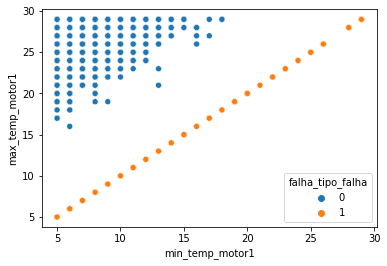

In [55]:
df_mergedminagg7 = df_mergedminagg2[['max_temp_motor1', 'max_temp_motor3', 'falha_tipo_falha']]
sns.scatterplot(data = df_mergedminagg2, x ='min_temp_motor1', y = 'max_temp_motor1', hue = 'falha_tipo_falha')

## FIM DO SMOTE

In [47]:
df_mergedminagg3 = df_mergedminagg2.sample(frac=1).reset_index(drop=True)

In [48]:
df_merged1 = df_merged1.drop(columns=['sensor_ip', 'sensor_id_cycle', 'sensor_unique_id', 'falha_error_description'])

In [53]:
df_merged1["falha_tipo_falha"].replace({"sem_falha": "0", "falha_1": "1","falha_2": "1", "falha_3": "1"}, inplace=True)

In [50]:
df_mergedminagg3["falha_tipo_falha"].replace({"sem_falha": "0", "falha_1": "1","falha_2": "1", "falha_3": "1"}, inplace=True)

KeyError: 'falha_tipo_falha'

In [51]:
df_mergedminagg2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6023 entries, 0 to 6022
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   min_humidity          6023 non-null   int64  
 1   max_humidity          6023 non-null   int64  
 2   avg_humidity          6023 non-null   float64
 3   min_temp_motor1       6023 non-null   int64  
 4   max_temp_motor1       6023 non-null   int64  
 5   avg_temp_motor1       6023 non-null   float64
 6   min_temp_motor2       6023 non-null   int64  
 7   max_temp_motor2       6023 non-null   int64  
 8   avg_temp_motor2       6023 non-null   float64
 9   min_temp_motor3       6023 non-null   int64  
 10  max_temp_motor3       6023 non-null   int64  
 11  avg_temp_motor3       6023 non-null   float64
 12  min_vibrationhz_x     6023 non-null   int64  
 13  max_vibrationhz_x     6023 non-null   int64  
 14  avg_vibrationhz_x     6023 non-null   float64
 15  min_vibrationhz_y    

In [52]:
df_merged1['falha_tipo_falha'] = pd.to_numeric(df_merged1['falha_tipo_falha'])

In [ ]:
df_mergedminagg3['falha_tipo_falha'] = pd.to_numeric(df_mergedminagg3['falha_tipo_falha'])

In [ ]:
df_mergedminagg3['falha_tipo_falha'] = pd.to_numeric(df_mergedminagg3['falha_tipo_falha'])

In [54]:
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
from typing import List
from statsmodels.stats.outliers_influence import variance_inflation_factor
import cane

def toInt(x):
    return int(x)

def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif.sort_values(["VIF"], ascending=False)
    return(vif)

def tratamento(dataframe: pd.DataFrame)-> pd.DataFrame: 

    for i in dataframe:
        if is_string_dtype(dataframe[i]):
            dataframe[i].fillna('Desconhecido', inplace=True)
        elif is_numeric_dtype(dataframe[i]): 
            dataframe[i].fillna(0, inplace=True)
        else: print(i)
    return dataframe

def object(dataframe: pd.DataFrame) -> List:

    col_obj = []
    for i in dataframe:
        if is_string_dtype(dataframe[i]):
            col_obj.append(i)
        else: print(i)
    return col_obj


def not_object(dataframe: pd.DataFrame) -> List:

    col_not_obj = []
    for i in dataframe:
        if is_string_dtype(dataframe[i]):
            print(i)
        else: col_not_obj.append(i)
    return col_not_obj

def idf_encode(train: pd.DataFrame, test: pd.DataFrame, list: List, target):

    _train = train.copy()
    _test = test.copy()

    dataIDF = cane.idf_multicolumn(_train, columns_use = list)  # aplication of specific multicolumn setting IDF

    idfDicionary = cane.idfDictionary(Original = _train, Transformed = dataIDF, columns_use = list
                                , targetColumn=target) #following the example above of the 2 columns
    for col in list:
        _test[col] = (
        _test[col]
        .map(idfDicionary[col])
        .fillna(max(idfDicionary[col].values()))
    )
        _train[col] = (
        _train[col]
        .map(idfDicionary[col])
        .fillna(max(idfDicionary[col].values()))
    )
    
    return _train, _test, idfDicionary

def NMAE(mae, y):
    ymax = y.max()
    ymin = y.min()
    dif = ymax-ymin
    nmae = mae/dif
    return nmae



In [ ]:
#df_mergedminagg4 = df_mergedminagg2.drop(columns=['temp_count_hour'])

In [55]:
df_merged1

,sensor_created_at,sensor_event_type,sensor_value_humidity,sensor_value_temperature_motor1,sensor_value_temperature_motor2,sensor_value_temperature_motor3,sensor_value_vibrationhz_x,sensor_value_vibrationhz_y,sensor_value_vibrationhz_z,value_noise_dba_motor1,value_noise_dba_motor2,value_noise_dba_motor3,falha_tipo_falha
0,2021-11-25 12:25:35.015,sensor,23,19,28,8,11,14,20,23,47,23,0
1,2021-11-25 12:25:40.016,sensor,22,26,21,27,19,16,20,39,58,46,0
2,2021-11-25 12:25:45.017,sensor,81,7,30,29,10,16,15,34,63,39,0
3,2021-11-25 12:25:50.019,sensor,41,18,23,11,18,11,21,26,20,44,0
4,2021-11-25 12:25:55.020,sensor,42,11,32,17,12,15,14,36,28,40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72235,2021-11-29 16:47:01.342,sensor,54,22,9,29,11,10,16,56,25,54,0
72236,2021-11-29 16:47:06.344,sensor,25,19,7,18,13,16,21,17,63,16,0
72237,2021-11-29 16:47:11.344,sensor,57,8,12,34,21,13,13,39,32,35,0
72238,2021-11-29 16:47:16.345,sensor,46,6,31,18,19,19,12,59,51,64,0


In [56]:
target = 'falha_tipo_falha'
#train, test = train_test_split(dfconceito, test_size=0.2, random_state=25)
train = df_merged1[0:60000]
test = df_merged1[60000:72240]
#col_obj=object(df_mergedminagg2)

#col_not_obj = not_object(df_mergedminagg2)
#col_not_obj.remove('falha_tipo_falha')

In [57]:
df_mergedminagg4

NameError: name 'df_mergedminagg4' is not defined

In [58]:
pip install boto3

     |████████████████████████████████| 131 kB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 11.7 MB/s eta 0:00:01
     |████████████████████████████████| 8.5 MB 20.8 MB/s eta 0:00:01███▌                | 4.1 MB 20.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [59]:
import boto3
import os

In [60]:
os.environ["MLFLOW_TRACKING_URI"] = "http://mlflow:5000"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://minio:9000"
os.environ["AWS_ACCESS_KEY_ID"] = "minio"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minio123"

In [61]:
from sklearn import metrics
from sklearn.metrics import accuracy_score as AUC
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve

In [63]:
train_h2o=h2o.H2OFrame(train)
test_h2o=h2o.H2OFrame(test)

print (train_h2o)

x = train_h2o.columns
y = target
x.remove(y)

print (x)
print (y)

train_h2o[y] = train_h2o[y].asfactor()
test_h2o[y] = test_h2o[y].asfactor()

experiment_name = 'provaconceito105'

client = MlflowClient()

try:
    experiment = mlflow.create_experiment(experiment_name)
except:
    experiment = client.get_experiment_by_name(experiment_name)
mlflow.set_experiment(experiment_name)


with mlflow.start_run():
    model = H2OAutoML(max_runtime_secs = 600, seed = 1, project_name = "provaconceito104", nfolds=10, sort_metric = 'AUC')
    model.train(x=x, y=y, training_frame = train_h2o)
   
    mlflow.log_param("runtime_sec", model.max_runtime_secs)
    mlflow.log_param("seed", model.seed)
    mlflow.log_param("nfolds", model.nfolds)
    mlflow.h2o.log_model(model.leader, "model")
    
    lb = model.leaderboard
    lb = get_leaderboard(model, extra_columns='ALL')
    print('')
    print(lb.head(rows=lb.nrows))
   # model.leader.varimp_plot()
    pred = model.predict(test_h2o)
    print(pred.head())
    pred_df = h2o.as_list(pred)

    perf = model.leader.model_performance(test_h2o)
    print(perf)
    print(test[y])
 #   auc = AUC(test[y], pred)
 #   precision, recall, thresholds = precision_recall_curve(test, pred_df)
  #  auc_precision_recall = auc(recall, precision)
  #  print(auc_precision_recall)
   # nmae = NMAE(mae, test[y])
  #  print('--------AUC-------', auc)
   # print('--------NMAE-------', nmae)
   # mlflow.log_metric("auc", auc)
    #print('--------AUC-------', AUC)
   # mlflow.log_metric("nmae", nmae)
    #exm = model.leader.explain_row(test_h2o, row_index=200)

#all_mlflow_runs = client.list_run_infos(experiment.experiment_id)
#if len(all_mlflow_runs) > 0:
#    run_info = all_mlflow_runs[-1]
#    model = mlflow.h2o.load_model("mlruns/{exp_id}/{run_id}/artifacts/model/".format(exp_id=experiment.experiment_id,run_id=run_info.run_uuid))
#    result = model.predict(test_h2o)
#else:
#    raise Exception('Run the training first')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


sensor_created_at,sensor_event_type,sensor_value_humidity,sensor_value_temperature_motor1,sensor_value_temperature_motor2,sensor_value_temperature_motor3,sensor_value_vibrationhz_x,sensor_value_vibrationhz_y,sensor_value_vibrationhz_z,value_noise_dba_motor1,value_noise_dba_motor2,value_noise_dba_motor3,falha_tipo_falha
2021-11-25 12:25:35,sensor,23,19,28,8,11,14,20,23,47,23,0
2021-11-25 12:25:40,sensor,22,26,21,27,19,16,20,39,58,46,0
2021-11-25 12:25:45,sensor,81,7,30,29,10,16,15,34,63,39,0
2021-11-25 12:25:50,sensor,41,18,23,11,18,11,21,26,20,44,0
2021-11-25 12:25:55,sensor,42,11,32,17,12,15,14,36,28,40,0
2021-11-25 12:26:00,sensor,35,18,10,23,12,17,15,21,54,36,0
2021-11-25 12:26:05,sensor,69,14,16,7,12,12,15,47,63,38,0
2021-11-25 12:26:10,sensor,39,16,6,32,12,15,13,21,27,37,0
2021-11-25 12:26:15,sensor,18,23,12,31,18,14,14,49,49,18,0
2021-11-25 12:26:20,sensor,18,16,7,6,21,17,17,34,33,48,0



['sensor_created_at', 'sensor_event_type', 'sensor_value_humidity', 'sensor_value_temperature_motor1', 'sensor_value_temperature_motor2', 'sensor_value_temperature_motor3', 'sensor_value_vibrationhz_x', 'sensor_value_vibrationhz_y', 'sensor_value_vibrationhz_z', 'value_noise_dba_motor1', 'value_noise_dba_motor2', 'value_noise_dba_motor3']
falha_tipo_falha
AutoML progress: |
16:15:59.119: New models will be added to existing leaderboard provaconceito104@@falha_tipo_falha (leaderboard frame=null) with already 4 models.

████████████████████████████████████████████████████
16:25:18.761: StackedEnsemble_AllModels_AutoML_20220112_161559 [StackedEnsemble all (built using all AutoML models)] failed: water.exceptions.H2OIllegalArgumentException: Failed to find the xval predictions frame. . .  Looks like keep_cross_validation_predictions wasn't set when building the models, or the frame was deleted.

████| 100%



model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
GBM_2_AutoML_20220112_161559,0.557698,0.0194469,0.00217632,0.493143,0.0498886,0.00248887,667,0.011577,GBM
GBM_grid__1_AutoML_20220112_161559_model_6,0.542872,0.0156227,0.00195082,0.495424,0.0439682,0.0019332,197,0.004557,GBM
GBM_grid__1_AutoML_20220112_161559_model_4,0.538345,0.0156287,0.00201626,0.487546,0.0414299,0.00171644,1251,0.01813,GBM
GBM_3_AutoML_20220112_161559,0.536851,0.0193679,0.00190741,0.497293,0.0508968,0.00259049,925,0.014914,GBM
GBM_grid__1_AutoML_20220112_161559_model_2,0.535964,0.0479933,0.00182817,0.462159,0.0729396,0.00532019,715,0.011409,GBM
XRT_1_AutoML_20220112_161559,0.51648,0.0446945,0.00231141,0.495207,0.0419185,0.00175716,889,0.015623,DRF
XGBoost_grid__1_AutoML_20220112_161559_model_4,0.504246,0.0157214,0.00165423,0.48312,0.0413869,0.00171287,2594,0.005434,XGBoost
DeepLearning_1_AutoML_20220112_161559,0.504131,0.0209104,0.00241742,0.486379,0.0412305,0.00169996,417,0.008712,DeepLearning
StackedEnsemble_BestOfFamily_AutoML_20220112_161559,0.501351,0.0125636,0.00172359,0.488279,0.041201,0.00169753,2257,0.014613,StackedEnsemble
DeepLearning_grid__1_AutoML_20220112_161559_model_1,0.498979,0.0188351,0.00171225,0.497118,0.0412301,0.00169992,579,0.005849,DeepLearning



gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
0,0.999676,0.000323629
0,0.999519,0.000481392
0,0.999809,0.00019106
0,0.998566,0.00143392
0,0.999825,0.000175115
0,0.999922,7.75362e-05
0,0.999678,0.00032206
0,0.999046,0.000954294
0,0.995533,0.00446729
0,0.999732,0.000268336




ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.002755897623450082
RMSE: 0.05249664392558902
LogLoss: 0.01970265472044264
Mean Per-Class Error: 0.4984041247237908
AUC: 0.3796624304849201
AUCPR: 0.0012521370377730251
Gini: -0.2406751390301598

Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.8925729987579436e-05: 


,,0,1,Error,Rate
0,0,39.0,12180.0,0.9968,(12180.0/12219.0)
1,1,0.0,21.0,0.0,(0.0/21.0)
2,Total,39.0,12201.0,0.9951,(12180.0/12240.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.000029,0.003436,398.0
1,max f2,0.000029,0.008547,398.0
2,max f0point5,0.000029,0.002151,398.0
3,max accuracy,0.999697,0.998203,0.0
4,max precision,0.000029,0.001721,398.0
5,max recall,0.000029,1.000000,398.0
6,max specificity,0.999697,0.999918,0.0
7,max absolute_mcc,0.000430,0.022118,358.0
8,max min_per_class_accuracy,0.000305,0.388984,370.0
9,max mean_per_class_accuracy,0.000029,0.501596,398.0



Gains/Lift Table: Avg response rate:  0.17 %, avg score:  0.26 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010049,2.901291e-02,0.000000,0.000000,0.000000,0.171912,0.000000,0.171912,0.000000,0.000000,-100.000000,-100.000000,-0.010066
1,2,0.020016,1.217344e-02,0.000000,0.000000,0.000000,0.018280,0.000000,0.095410,0.000000,0.000000,-100.000000,-100.000000,-0.020051
2,3,0.030065,6.988847e-03,0.000000,0.000000,0.000000,0.009080,0.000000,0.066555,0.000000,0.000000,-100.000000,-100.000000,-0.030117
3,4,0.040033,4.742573e-03,0.000000,0.000000,0.000000,0.005644,0.000000,0.051389,0.000000,0.000000,-100.000000,-100.000000,-0.040101
4,5,0.050000,3.702980e-03,0.000000,0.000000,0.000000,0.004177,0.000000,0.041978,0.000000,0.000000,-100.000000,-100.000000,-0.050086
5,6,0.100000,1.747458e-03,0.952381,0.476190,0.001634,0.002513,0.000817,0.022245,0.047619,0.047619,-4.761905,-52.380952,-0.052471
6,7,0.150000,1.233106e-03,0.000000,0.317460,0.000000,0.001464,0.000545,0.015318,0.000000,0.047619,-100.000000,-68.253968,-0.102557
7,8,0.200000,9.270039e-04,0.952381,0.476190,0.001634,0.001064,0.000817,0.011755,0.047619,0.095238,-4.761905,-52.380952,-0.104942
8,9,0.300000,6.300235e-04,0.952381,0.634921,0.001634,0.000759,0.001089,0.008089,0.095238,0.190476,-4.761905,-36.507937,-0.109712
9,10,0.400000,4.781799e-04,0.000000,0.476190,0.000000,0.000548,0.000817,0.006204,0.000000,0.190476,-100.000000,-52.380952,-0.209884




60000    0
60001    0
60002    0
60003    0
60004    0
        ..
72235    0
72236    0
72237    0
72238    0
72239    0
Name: falha_tipo_falha, Length: 12240, dtype: int64


In [ ]:
df_mergedminagg3 

In [ ]:
predict = model.predict(test_h2o)

In [ ]:
predict

In [ ]:
model.leader.varimp_plot()

In [ ]:
pred_df = pred_df.reset_index(drop=True)

In [ ]:
pred_df.index += 6000

In [ ]:
pred_df

In [ ]:
test

In [ ]:
pip install plotly

In [ ]:
import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train['falha_tipo_falha'],label="Training")
plt.plot(test['falha_tipo_falha'],label="Test")
plt.plot(pred_df,label="Predicted")
plt.xlim([6000,6145])
plt.show()


# 9. Auto-Arima

In [ ]:
pip install pmdarima

In [ ]:
pip install matplotlib

In [ ]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd

In [ ]:
dfarima = dfminagg

In [ ]:
dfarima

In [ ]:
dfarimadrop = dfarima.drop(columns=['sensor_datehhmm', 'sensor_ip', 'min_humidity', 'avg_humidity', 'max_humidity', 'min_temp_motor1', 'max_temp_motor1', 'min_temp_motor2', 'max_temp_motor2', 'avg_temp_motor2', 'min_temp_motor3', 'max_temp_motor3', 'avg_temp_motor3', 'min_noise_dba_motor1', 'avg_noise_dba_motor1', 'max_noise_dba_motor1', 'min_noise_dba_motor2', 'avg_noise_dba_motor2', 'max_noise_dba_motor2', 'min_noise_dba_motor3', 'avg_noise_dba_motor3', 'max_noise_dba_motor3', 'temp_count_hour', 'min_vibrationhz_x', 'avg_vibrationhz_x', 'max_vibrationhz_x', 'min_vibrationhz_y', 'avg_vibrationhz_y', 'max_vibrationhz_y', 'min_vibrationhz_z', 'avg_vibrationhz_z', 'max_vibrationhz_z'])


In [ ]:
dfarimadrop

In [ ]:
dfarimadrop.to_csv('./provaconceito/csv/dfarima.csv', index=False)

In [ ]:
pip install cane

In [ ]:
def hold(y, ratio=2 / 3, mode="rolling", it=1, window=10, increment=1):
    #ratio = test size
    #window = traingin size
    ALLITR = None
    VAL = None
    NSIZE = len(y)
    if mode == "incremental" or mode == "rolling":
        aux = window + increment * (it - 1)
        aux = min(aux, NSIZE)
        if mode == "rolling":
            iaux = max((aux - window + 1), 1)
        else:
            iaux = 1
        ALLTR = range(iaux, aux)
        end = aux + ratio
        end = min(end, NSIZE)
        iend = aux + 1
        if iend < end:
            TS = range(iend, end)
        else:
            TS = None
    return {"tr": ALLTR, "itr": ALLITR, "val": VAL, "ts": TS}

In [ ]:
def calcIterationsRW(datasetSize, trainingSize, testSize, stepSize): 
    
    return int((datasetSize - (trainingSize + testSize))/ stepSize)

trainingSize = 1023
testSize = 15
ratio = testSize
stepSize = 200
#totalLenght = df.shape[0]
mode = "rolling"

iterations = calcIterationsRW(dfarimadrop.shape[0], trainingSize, testSize, stepSize)

#For only positive records
#iterations = calcIterationsRW(len(df['serial'].unique()), trainingSize, testSize, stepSize)

iterations

# 10. Prophet


![prophet2](./images/prophet2.png)

#### Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [ ]:
pip install pystan==2.19.1.1

In [ ]:
pip install fbprophet

In [ ]:
pip install prophet

In [ ]:
dfprophet = dfconceito2.drop(columns=['sensor_ip', 'min_humidity', 'avg_humidity', 'max_humidity', 'min_temp_motor1', 'max_temp_motor1', 'min_temp_motor2', 'max_temp_motor2', 'avg_temp_motor2', 'min_temp_motor3', 'max_temp_motor3', 'avg_temp_motor3', 'min_noise_dba_motor1', 'avg_noise_dba_motor1', 'max_noise_dba_motor1', 'min_noise_dba_motor2', 'avg_noise_dba_motor2', 'max_noise_dba_motor2', 'min_noise_dba_motor3', 'avg_noise_dba_motor3', 'max_noise_dba_motor3', 'temp_count_hour', 'min_vibrationhz_x', 'avg_vibrationhz_x', 'max_vibrationhz_x', 'min_vibrationhz_y', 'avg_vibrationhz_y', 'max_vibrationhz_y', 'min_vibrationhz_z', 'avg_vibrationhz_z', 'max_vibrationhz_z'])

In [ ]:
dfprophet

In [ ]:
dfprophet.to_csv('./dfprophet.csv', index=False)

In [ ]:
def hold(y, ratio=2 / 3, mode="rolling", it=1, window=10, increment=1):
    #ratio = test size
    #window = traingin size
    ALLITR = None
    VAL = None
    NSIZE = len(y)
    if mode == "incremental" or mode == "rolling":
        aux = window + increment * (it - 1)
        aux = min(aux, NSIZE)
        if mode == "rolling":
            iaux = max((aux - window + 1), 1)
        else:
            iaux = 1
        ALLTR = range(iaux, aux)
        end = aux + ratio
        end = min(end, NSIZE)
        iend = aux + 1
        if iend < end:
            TS = range(iend, end)
        else:
            TS = None
    return {"tr": ALLTR, "itr": ALLITR, "val": VAL, "ts": TS}

In [ ]:
def calcIterationsRW(datasetSize, trainingSize, testSize, stepSize): 
    
    return int((datasetSize - (trainingSize + testSize))/ stepSize)

trainingSize = 1023
testSize = 15
ratio = testSize
stepSize = 200
#totalLenght = df.shape[0]
mode = "rolling"

iterations = calcIterationsRW(dfprophet.shape[0], trainingSize, testSize, stepSize)

#For only positive records
#iterations = calcIterationsRW(len(df['serial'].unique()), trainingSize, testSize, stepSize)

iterations

In [ ]:
dfprophet2 = dfprophet.rename({'sensor_datehhmm': 'ds', 'avg_temp_motor1' : 'y'}, axis=1)  # new method   

In [ ]:
dfprophet2['ds'] = pd.to_datetime(dfprophet2['ds'])

In [ ]:
from fbprophet import Prophet
from tqdm import trange
from sklearn.metrics import mean_absolute_error

def runprophet(data, iterations):
    max_value = data['y'].max()
    min_value = data['y'].min()
    denominator = max_value - min_value
    
    print(min_value)
    print(max_value)
    
    dfFinal = pd.DataFrame(columns = ['MAE', 'NMAE'])
    
    MAEVals = []
    NMAEVals = []
   
    for i in trange(iterations):
        
            print(min_value)
            print(data['y'])

            holds = hold(data['y'], ratio, mode, i+1, trainingSize, stepSize)
            print('holds')
            print("Iteration ", i+1 , "of ", iterations, " TR: ", holds['tr'] , "TS: ", holds['ts'])
            
            print(min_value)
            tr = data.iloc[holds['tr']].reset_index(drop=True)
            ts = data.iloc[holds['ts']].reset_index(drop=True)
            
            m = Prophet()
            m.fit(tr)

            p = m.predict(ts)
            
            print(ts)
            print(p)
            
            MAE = mean_absolute_error(ts['y'].values.tolist(), p['yhat'])
            NMAE = (MAE/denominator)*100 #o denominador é calculado com o maximo e minimo global
            
            print("Iteration ", i , "MAE ", MAE, "NMAE of ", NMAE)
            
            MAEVals.append(MAE)
            NMAEVals.append(NMAE)
        
            new = {'MAE': MAE, 'NMAE': NMAE}
            dfFinal = dfFinal.append(new, ignore_index=True)
            dfFinal = pd.DataFrame(dfFinal)
            
    return dfFinal

In [ ]:
dfprophet2.info()

In [ ]:
dfResults = runprophet(dfprophet2,iterations)

In [ ]:
train = dfprophet2[0:5900]
test = dfprophet2[5900:6022]

#train, test = train_test_split(df, test_size=0.2)

    
m = Prophet()
m.fit(train)

p = m.predict(test)

print(p)